In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt

In [2]:
args = {}
args["data_dir"] = "data/segmentation02/segmentation"
args["data"] = "segmentation02"
args["lr"] = 0.01
utils.create_data_file_lists(args["data_dir"])
utils.split_train_to_val(args["data"], args["data_dir"], val_ratio=0.1)

In [3]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["train", "val"], batch_size=4, num_workers=8
        )

In [4]:
import timm
class UNet(nn.Module):
    def __init__(self, num_classes=4, encoder_name='resnet18.a1_in1k'):
        super(UNet, self).__init__()
        self.encoder = timm.create_model(encoder_name, pretrained=True, features_only=True, out_indices=[0,1,2,3,4])

        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sequential(
                nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
            ),
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sequential(
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
            )
        ])
        self.final_1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.final_2 = nn.Sequential(
            nn.Conv2d(64, num_classes, kernel_size=1)
        )
        self.act = nn.Sigmoid()

    def forward(self, x):
        encoder_features = []
        encoder_features = self.encoder(x)
        x = encoder_features[-1].clone()
        
        for i, module in enumerate(self.decoder):
            x = module(x)
            x = torch.cat([x, encoder_features[-(i + 2)]], dim=1)
        
        x = self.final_1(x)
        x = self.upsample(x)
        x = self.final_2(x)
        return self.act(x)

/Users/rishitoshsingh/miniconda3/envs/dl-asign/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def get_device(device_str):
    if device_str == "gpu" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_str == "cpu":
        return torch.device("cpu")
    elif device_str == "mps" and torch.backends.mps.is_available():
        return torch.device("mps")  # You can modify the GPU index if needed
    else:
        print("Warning: Invalid device option. Using CPU.")
        return torch.device("cpu")
device = get_device("cpu")

In [7]:
# model = UNet()
model = UNet(num_classes=4)
loss_fn = nn.BCELoss()
# loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
model = model.to(device)

In [8]:
from torchsummary import summary
summary(model.to(torch.device("cpu")), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
          Identity-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
          Identity-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
       BasicBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

In [9]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [10]:
images, masks = next(iter(dataloaders["train"]))
print(images.shape, masks.shape)

torch.Size([4, 1, 256, 256]) torch.Size([4, 4, 256, 256])


In [11]:
masks.min(), masks.max()

(tensor(0.), tensor(1.))

In [12]:
def mask_class_to_image(tensor):
  if tensor.ndim == 3:
    tmp = tensor.argmax(dim=0)
  else:
    tmp = tensor.argmax(dim=1)
  tmp = tmp / tmp.max()
  return tmp
def mask_class_to_image(tensor):
  tensor = tensor / tensor.max()
  return tensor

def masks_to_inage(masks):
  output_masks = torch.argmax(masks, dim=1)
  output_masks = output_masks / output_masks.max()
  return output_masks

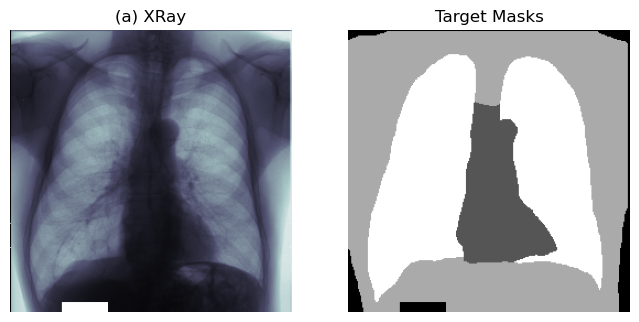

In [13]:
idx=0
fig=plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.imshow(image_to_arrag(images[idx]), cmap=plt.cm.bone)
plt.title("(a) XRay")
plt.axis("off")
fig.add_subplot(122)
plt.imshow(masks_to_inage(masks)[idx], cmap="gray")
plt.title("Target Masks")
plt.axis("off")
plt.show()

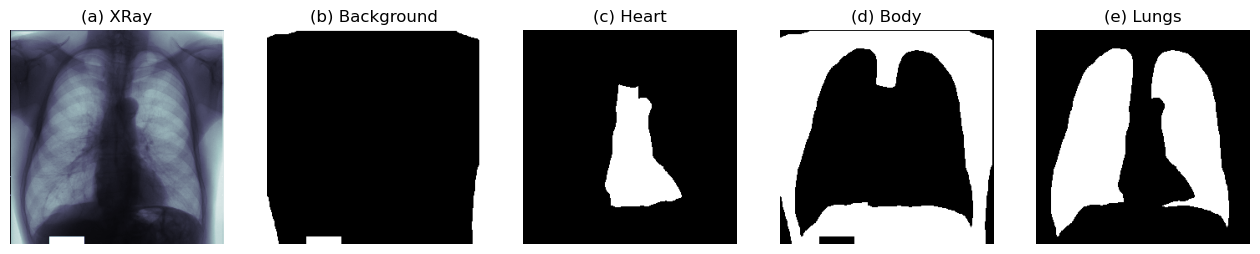

In [14]:
idx=0
fig=plt.figure(figsize=(16,4))
fig.add_subplot(151)
plt.imshow(image_to_arrag(images[idx]), cmap=plt.cm.bone)
plt.title("(a) XRay")
plt.axis("off")
fig.add_subplot(152)
plt.imshow(masks[idx][0], cmap="gray")
plt.title("(b) Background")
plt.axis("off")
fig.add_subplot(153)
plt.imshow(masks[idx][1], cmap="gray")
plt.title("(c) Heart")
plt.axis("off")
fig.add_subplot(154)
plt.imshow(masks[idx][2], cmap="gray")
plt.title("(d) Body")
plt.axis("off")
fig.add_subplot(155)
plt.imshow(masks[idx][3], cmap="gray")
plt.title("(e) Lungs")
plt.axis("off")
plt.show()

In [15]:
from tqdm import tqdm

In [16]:
def train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, num_epochs, mode):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()
            running_loss=0.0
            with tqdm(total=len(dataloaders[phase]), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.repeat(1, 3, 1, 1)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase=="train"):
                        outputs = model(inputs)
                        # print(outputs.min(), outputs.max())
                        loss = loss_fn(outputs, labels)
                        # print(loss.shape, loss)
                        if phase=="train":
                            loss.backward()
                            optimizer.step()
                        running_loss += loss.item()
                    pbar.update(1)
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, 10, "segmentation")

Val Epoch 1/10: 100%|██████████| 5/5 [00:29<00:00,  5.84s/batch]


Epoch 1/10 -> Train Loss: 0.0899, Val Loss: 0.0576


Val Epoch 2/10: 100%|██████████| 5/5 [00:29<00:00,  5.84s/batch]


Epoch 2/10 -> Train Loss: 0.0275, Val Loss: 0.0233


Val Epoch 3/10: 100%|██████████| 5/5 [00:29<00:00,  5.85s/batch]


Epoch 3/10 -> Train Loss: 0.0187, Val Loss: 0.0175


Val Epoch 4/10: 100%|██████████| 5/5 [00:29<00:00,  5.84s/batch]


Epoch 4/10 -> Train Loss: 0.0168, Val Loss: 0.0144


Val Epoch 5/10: 100%|██████████| 5/5 [00:29<00:00,  5.85s/batch]


Epoch 5/10 -> Train Loss: 0.0152, Val Loss: 0.0156


Val Epoch 6/10: 100%|██████████| 5/5 [00:29<00:00,  5.88s/batch]


Epoch 6/10 -> Train Loss: 0.0142, Val Loss: 0.0162


Val Epoch 7/10: 100%|██████████| 5/5 [00:29<00:00,  5.81s/batch]


Epoch 7/10 -> Train Loss: 0.0138, Val Loss: 0.0133


Val Epoch 8/10: 100%|██████████| 5/5 [00:29<00:00,  5.83s/batch]


Epoch 8/10 -> Train Loss: 0.0122, Val Loss: 0.0123


Val Epoch 9/10: 100%|██████████| 5/5 [00:29<00:00,  5.89s/batch]


Epoch 9/10 -> Train Loss: 0.0116, Val Loss: 0.0141


Val Epoch 10/10: 100%|██████████| 5/5 [00:29<00:00,  5.82s/batch]

Epoch 10/10 -> Train Loss: 0.0144, Val Loss: 0.0390


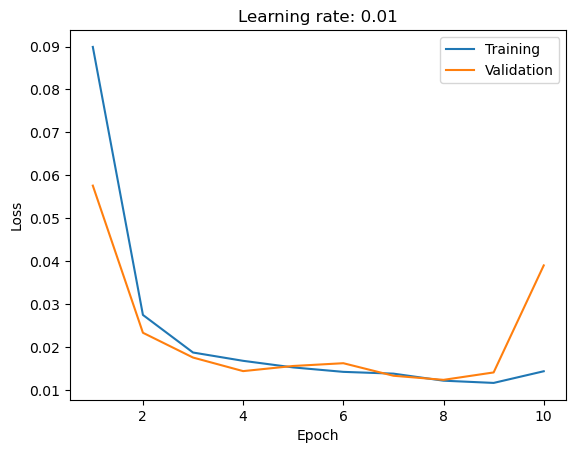

In [17]:
def plot_loss(train_losses, val_losses, learning_rate):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning rate: {learning_rate}")
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses, args["lr"])

In [18]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"]
        )

In [21]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.repeat(1, 3, 1, 1))
            loss = loss_fn(outputs, labels)
            # loss = torch.mean(channel_weights*loss)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
    test_loss = test_loss / dataset_size
    all_inputs, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_outputs, all_targets
inputs, outputs, targets = test_model(model, loss_fn, dataloaders["test"], dataset_sizes["test"])

Test Loss: 0.0287


In [36]:
def calculate_iou(pred_masks, true_masks, threshold=0.5):
    # Binarize predicted masks based on the threshold
    pred_masks = (pred_masks > threshold).float()

    intersection = torch.sum(pred_masks * true_masks, dim=(2, 3))  # Intersection
    union = torch.sum(pred_masks + true_masks, dim=(2, 3)) - intersection  # Union

    iou = intersection / (union + 1e-8)  # Add epsilon to avoid division by zero
    return torch.mean(iou)
print("mIoU: ", calculate_iou(outputs, targets, 0.5))
for channel, mask in zip(range(4),["Background","Heart","Body","Lungs"]):
    print(f"mDICE: {mask}: ", calculate_iou(outputs[:,channel:channel+1,:,:], targets[:,channel:channel+1,:,:], 0.5).item())

mIoU:  tensor(0.7807)
mDICE: Background:  0.6234108805656433
mDICE: Heart:  0.7340605854988098
mDICE: Body:  0.8840628266334534
mDICE: Lungs:  0.8813994526863098


In [35]:
def calculate_dice(pred_masks, true_masks, threshold=0.5):
    # Binarize predicted masks based on the threshold
    pred_masks = (pred_masks > threshold).float()

    intersection = torch.sum(pred_masks * true_masks, dim=(2, 3))  # Intersection
    sum_masks = torch.sum(pred_masks + true_masks, dim=(2, 3))  # Sum of masks

    dice = 2. * intersection / (sum_masks + 1e-8)  # Add epsilon to avoid division by zero
    return torch.mean(dice)
print("mDICE: ", calculate_dice(outputs, targets, 0.5).item())
for channel, mask in zip(range(4),["Background","Heart","Body","Lungs"]):
    print(f"mDICE: {mask}: ", calculate_dice(outputs[:,channel:channel+1,:,:], targets[:,channel:channel+1,:,:], 0.5).item())

mDICE:  0.8625368475914001
mDICE: Background:  0.7365661263465881
mDICE: Heart:  0.8404067158699036
mDICE: Body:  0.9368516802787781
mDICE: Lungs:  0.9363223910331726


In [24]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [25]:
outputs.max(), outputs.min()

(tensor(1.), tensor(2.0180e-15))

In [26]:
idx=0
mask_i=1
outputs[idx][mask_i].min(), outputs[idx][mask_i].max(),

(tensor(8.9655e-08), tensor(1.))

In [27]:
output_masks = torch.argmax(outputs, dim=1)
output_masks = output_masks / output_masks.max()

In [28]:
target_masks = torch.argmax(targets, dim=1)
target_masks = target_masks / target_masks.max()

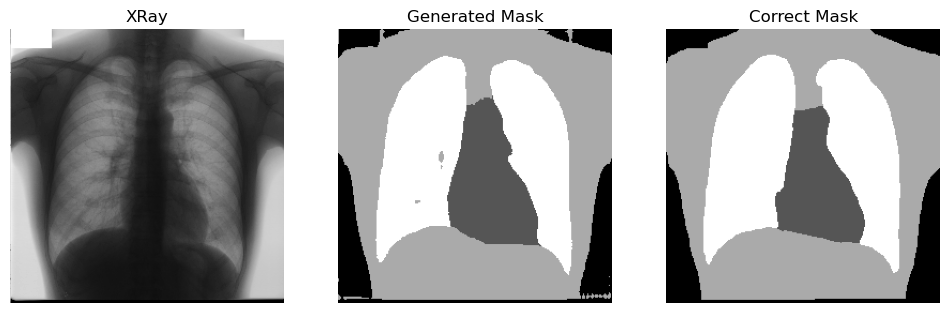

In [29]:
def plot_result(ip, output, target):
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(131)
    plt.imshow(image_to_arrag(ip), cmap="gray")
    plt.title("XRay")
    plt.axis('off')
    fig.add_subplot(132)
    plt.imshow(output, cmap="gray")
    plt.title("Generated Mask")
    plt.axis('off')
    fig.add_subplot(133)
    plt.imshow(target, cmap="gray")
    plt.title("Correct Mask")
    plt.axis('off')
    plt.show()
idx=12
plot_result(inputs[idx], output_masks[idx], target_masks[idx])

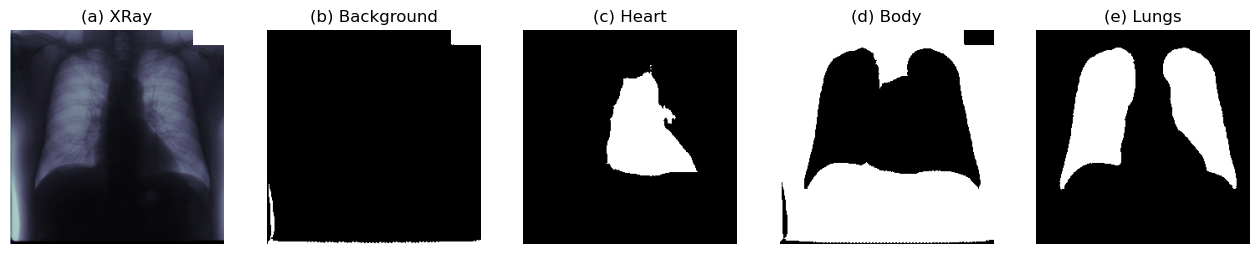

In [30]:
idx=0
outputs_sep=(outputs>0.5).float()
fig=plt.figure(figsize=(16,4))
fig.add_subplot(151)
plt.imshow(image_to_arrag(inputs[idx]), cmap=plt.cm.bone)
plt.title("(a) XRay")
plt.axis("off")
fig.add_subplot(152)
plt.imshow(outputs_sep[idx][0], cmap="gray")
plt.title("(b) Background")
plt.axis("off")
fig.add_subplot(153)
plt.imshow(outputs_sep[idx][1], cmap="gray")
plt.title("(c) Heart")
plt.axis("off")
fig.add_subplot(154)
plt.imshow(outputs_sep[idx][2], cmap="gray")
plt.title("(d) Body")
plt.axis("off")
fig.add_subplot(155)
plt.imshow(outputs_sep[idx][3], cmap="gray")
plt.title("(e) Lungs")
plt.axis("off")
plt.show()